# 面向光纤的SSFM求解器

In [3]:
# 导入
from WaveGenerator import BasicWaveGenerator
from SSFMSolver import SSFMSolver

import numpy as np


## 波形发生器（WaveGenerator）

根据输入的比特数组与仿真参数生成波形。

### 成员变量

- `bps`: 比特率，二进制下等效于波特率，单位为bit per second.

- `fs`: 采样率，决定了数字仿真中能够计算的频率范围，应保证能够覆盖信号的绝大部分频谱，在WDM中需要格外注意。单位为Hz.

- `basicWave`: 基带脉冲波形，支持矩形脉冲`Square`，高斯脉冲`Gaussian`，升余弦脉冲`RaisedCosine`或`RC`，配合参数`alpha`使用。

- `alpha`: 在高斯脉冲中，等效于$\pi T_0$，其中$T_0$为脉冲半宽，单位为s；在升余弦脉冲中表示滚降系数，取值范围为[0,1]。（实际上数字仿真中$\alpha=0$是不可达的，会用一个非常小的常数替代）

- `bits`: 输入的比特数组，由数字0和1组长的行向量。

- `n`: 比特数组的长度，包括自动补零。

- `Ns`: 每比特对应的采样点数，即`fs/bps`。

- `N`: 总的采样点数，等于`Ns*n`。

- `waveform`: 生成的波形，由`N`个采样点组成的行向量。

- `t` `f` `w`: 波形或其频谱对应的时间轴、频率以及角频率。

- `filter`: 脉冲成形滤波器，仅在高斯、升余弦脉冲中有效，长度为`N`。

### 成员函数

- 构造函数以及`setBps` `setFs` `setBasicWave` `setBits`: 设置相应参数，支持链式调用。

- `generate`: 生成波形及时间、频率轴。接受一个参数控制返回的频率类型，默认全部返回。

- `plot`: 绘制产生的波形及其频谱。

- `info`: 在控制台输出波形相关信息，包括码元持续时间、高斯脉冲半宽等。

- `zeroAdder`: 在比特序列首位补零，常用于单脉冲仿真中时间轴范围不足的简化修复措施。

- `demodulator`: 返回一个与当前发生器相适配的解调器。

### 派生类

- `WDMWaveGenerator`: 添加`setWDM`函数设置复用的通道数量、中心频率、通道间隔等，单位为Hz。`setBits`函数被重写，接收c\*n的矩阵作为比特输入，其中c为通道数。

- `PDMWaveGenerator`: `setBits`函数被重写，接收两个c\*n的矩阵作为两个偏振方向上的比特输入，其中c为通道数。返回的`waveform`为2\*N的矩阵，分别为两个偏振方向上的波形。

## SSFM求解器（SSFMSolver）

### 成员变量

- `alphaDB` `alpha`: 衰减系数，各自的单位如字面意思

- `beta`: 色散系数，接受行向量作为输入，各元素表示二、三……阶色散系数，单位为$ps^k/km$其中$k$为色散阶数。

- `gamma`: 非线性系数，单位为$W^{-1}/km$

- `L`: 光纤长度，单位为$km$

- `dz`: 空间步长，单位为$km$

- `input`: 输入波形，单位视作$W^{-\frac{1}{2} }$。请直接使用WaveGenerator的输出。

- `t`: 时间轴，输入单位为$s$，自动转换为$ps$。

- `w`: 频率轴，输入单位为$Hz$，自动转换为$THz$。

- `output`: 输出波形，单位视作$W^{-\frac{1}{2} }$。

- `title`: 标题，用于区分不同求解器，当然也可以不设置。

### 成员函数

- 构造函数以及`setAlpha` `setBeta` `setGamma` `setL` `setDz` `setInput`:  设置相应参数，支持链式调用。

- `usePDM`: 设置是否为PDM，这将影响期望的输入与求解形式。

- `linearOperator`: 基于频率轴，计算指定空间步长下的线性算子。

- `nonlinearOperator`: 基于输入波形计算指定步长下的非线性算子。

- `propagate`: 计算光纤的输出。

- `plot`: 绘制光纤的输出，自动补偿衰减。

## 相干解调器（Demodulator）

进行相干解调，输出比特，绘制星座图。
注：目前仅支持OOK的非相干解调。

### 成员变量

- `bps` `fs`: 参见波形发生器。在发生器与解调器之间应保持一致。

- `filter`: 基带成形滤波器的频谱，自动降采样至`Ns`点。

- `signal`: 将进行解调的信号。

- `bits`: 解调结果。

- `correctBits`: 期望的结果/正确的比特。

### 成员函数

- 构造函数及`setBps` `setFs` `setFilter` `setSignal` `setCorrectBits`：设置相应成员变量，支持链式调用。

- `demodulate`：解调函数，将信号进行相干解调，输出比特。

- `plotConstellation`：绘制星座图。

## 示例

bps: 1.00e+09
fs: 2.00e+13Hz
Symbol Period: 1000.00ps
basicWave: Gaussian
Half width: 93.69ps


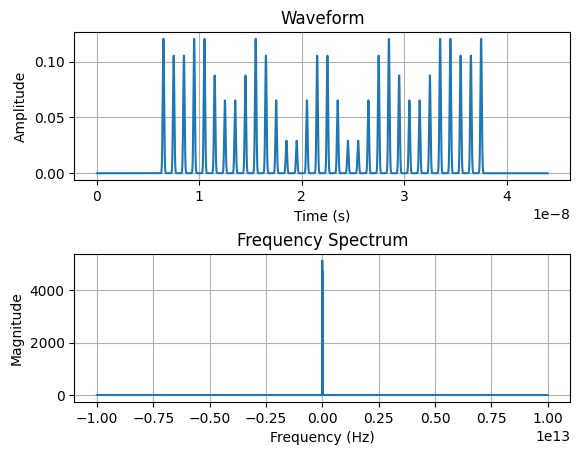

In [4]:
# Generate waveform
gen = BasicWaveGenerator(bps=1e9, fs=2e13, basicWave='Gaussian')\
    .setBits(np.arange(stop=32)).modulation(method='32QAM', minEnergy=2).addZero(6)
gen.info()
gen.plot()
signal, t, f, w = gen.generate(freqType='all')
# print(gen.Ns * np.sum(np.abs(np.fft.ifft(gen.filter))**2), gen.alpha, np.sqrt(np.pi/2)/0.2944)


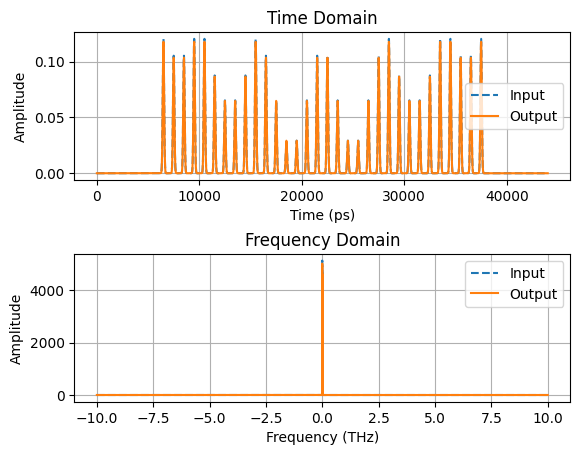

In [5]:
# Transport through optical fiber
fiber = SSFMSolver(alphaDB=0.2, beta=[2, 0], gamma=2, L=100, dz=0.5, title='test')
fiber.setInput(signal, t, w)
fiber.propagate()
fiber.plot()

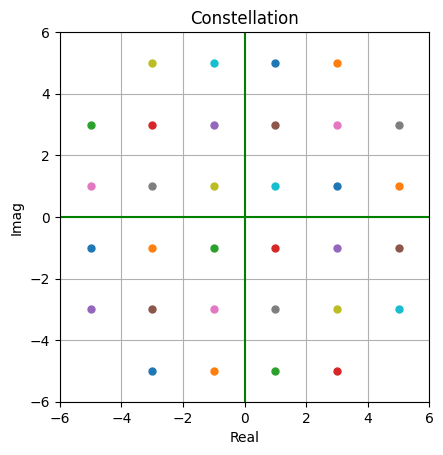

[-3.-5.j -1.-5.j  1.-5.j  3.-5.j -5.-3.j -3.-3.j -1.-3.j  1.-3.j  3.-3.j
  5.-3.j -5.-1.j -3.-1.j -1.-1.j  1.-1.j  3.-1.j  5.-1.j -5.+1.j -3.+1.j
 -1.+1.j  1.+1.j  3.+1.j  5.+1.j -5.+3.j -3.+3.j -1.+3.j  1.+3.j  3.+3.j
  5.+3.j -3.+5.j -1.+5.j  1.+5.j  3.+5.j]


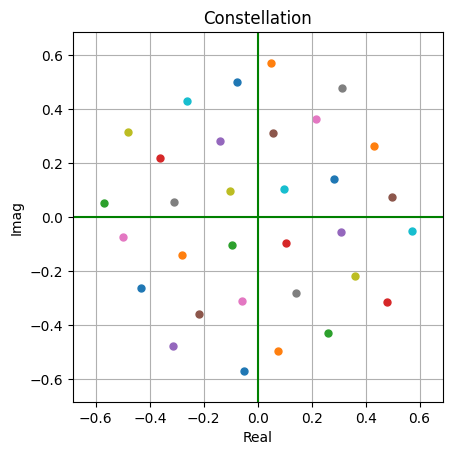

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [6]:
# Demodulate
dem = gen.demodulator()
# print(gen.Ns * np.sum(np.abs(np.fft.ifft(dem.filter))**2), gen.alpha, np.sqrt(np.pi/2)/(gen.bps*gen.alpha))
# original
dem.setSignal(gen.waveform)
dem.demodulate()
dem.plotConstellation()
print(dem.samples)
# fiber: 100km
dem.setSignal(fiber.output)
dem.demodulate()
dem.plotConstellation()

print(dem.correct)


In [7]:
print(dem.correct)
print(dem.samples)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[-0.05094726-0.57079914j  0.07558018-0.49879958j  0.26161231-0.43136108j
  0.47967112-0.31356483j -0.31356483-0.47967112j -0.21732917-0.36161907j
 -0.0567985 -0.31040254j  0.14080272-0.28240113j  0.36161907-0.21732917j
  0.57079914-0.05094726j -0.43136108-0.26161231j -0.28240113-0.14080272j
 -0.09617535-0.10362588j  0.10362588-0.09617535j  0.31040254-0.0567985j
  0.49879958+0.07558018j -0.49879958-0.07558018j -0.31040254+0.0567985j
 -0.10362588+0.09617535j  0.09617535+0.10362588j  0.28240113+0.14080272j
  0.43136108+0.26161231j -0.57079914+0.05094726j -0.36161907+0.21732917j
 -0.14080272+0.28240113j  0.0567985 +0.31040254j  0.21732917+0.36161907j
  0.31356483+0.47967112j -0.47967112+0.31356483j -0.26161231+0.43136108j
 -0.07558018+0.49879958j  0.05094726+0.57079914j]
